
[notice] A new release of pip is available: 24.3.1 -> 26.0.1
[notice] To update, run: pip install --upgrade pip


[*********************100%***********************]  1 of 1 completed
2026-02-06 15:48:44.508703: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2026-02-06 15:48:44.508770: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2026-02-06 15:48:44.508779: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.92 GB
2026-02-06 15:48:44.508822: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2026-02-06 15:48:44.508836: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Bentuk dataset setelah diperbaiki: (1710, 1)


/Users/rifai/.pyenv/versions/3.12.8/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10


2026-02-06 15:48:46.707391: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - loss: 0.0229
Epoch 2/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0037
Epoch 3/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0034
Epoch 4/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0028
Epoch 5/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0025
Epoch 6/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0025
Epoch 7/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0022
Epoch 8/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0024
Epoch 9/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0024
Epoch 10/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0019
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step


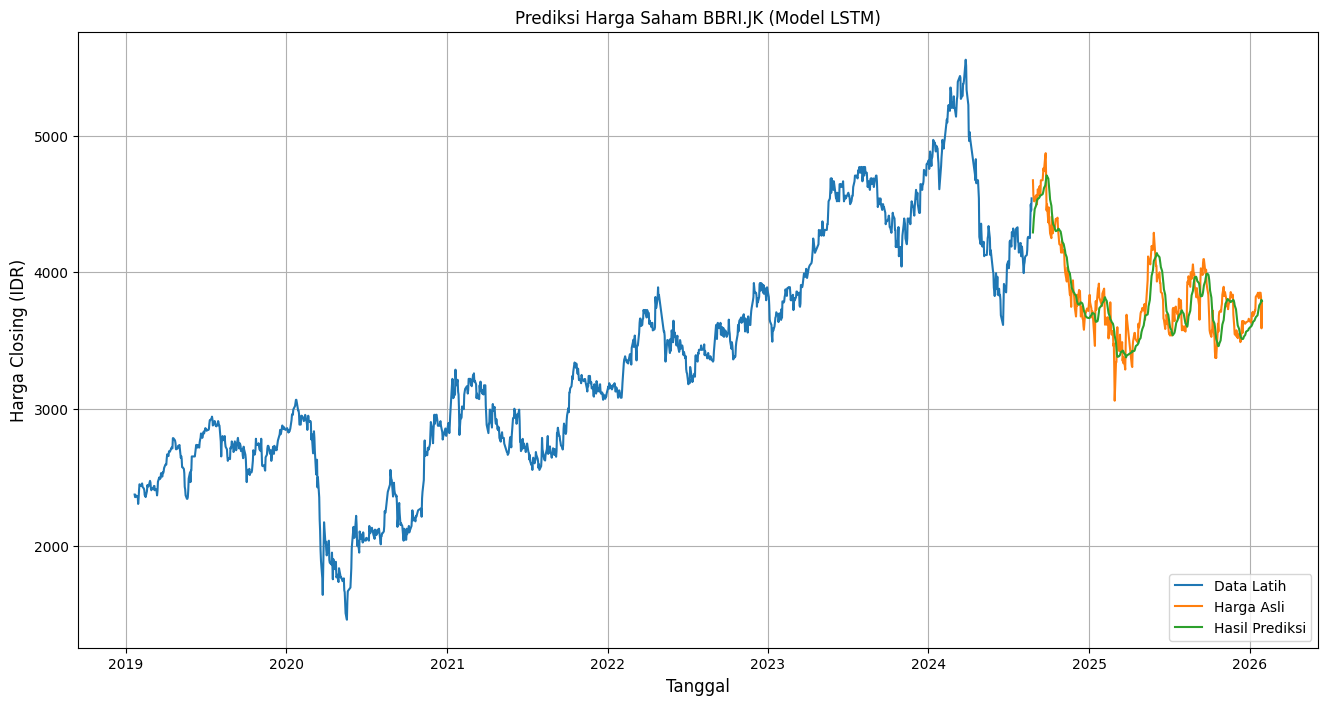

In [1]:
# 1. Install & Upgrade
!pip install --upgrade yfinance pandas_datareader

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

# --- PERBAIKAN PENGAMBILAN DATA ---
symbol = 'BBRI.JK'
start_date = '2019-01-20'
end_date = '2026-01-30'

# Menggunakan auto_adjust agar format kolom lebih konsisten
df = yf.download(symbol, start=start_date, end=end_date, auto_adjust=True)

# Memastikan kita mengambil kolom 'Close' meskipun dalam format MultiIndex
if 'Close' in df.columns:
    data = df[['Close']]
else:
    # Jika yfinance menggunakan MultiIndex (misal: ('Close', 'BBRI.JK'))
    data = df.xs('Close', axis=1, level=0) if isinstance(df.columns, pd.MultiIndex) else df[['Close']]

# Menghapus data kosong (NaN) jika ada
data = data.dropna()
dataset = data.values

print(f"Bentuk dataset setelah diperbaiki: {dataset.shape}")

# 2. Preprocessing Data
training_data_len = int(np.ceil(len(dataset) * .8))

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

# Membuat dataset training
x_train, y_train = [], []
for i in range(60, len(scaled_data[:training_data_len])):
    x_train.append(scaled_data[i-60:i, 0])
    y_train.append(scaled_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

# 3. Membangun Model LSTM
#
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size=32, epochs=10, verbose=1)

# 4. Pengujian Model
test_data = scaled_data[training_data_len - 60: , :]
x_test = []
y_test = dataset[training_data_len:, :]

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# 5. Visualisasi
train = data[:training_data_len]
valid = data[training_data_len:].copy()
valid['Predictions'] = predictions

plt.figure(figsize=(16,8))
plt.title(f'Prediksi Harga Saham {symbol} (Model LSTM)')
plt.xlabel('Tanggal', fontsize=12)
plt.ylabel('Harga Closing (IDR)', fontsize=12)
plt.plot(train['Close'], label='Data Latih')
plt.plot(valid['Close'], label='Harga Asli')
plt.plot(valid['Predictions'], label='Hasil Prediksi')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()